<a href="https://colab.research.google.com/github/gilvandrocesardemedeiros/Meteorology_replace-missing-values/blob/master/Replace_Missing_Values_Temperature%5BBeloHorizonte%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
from datetime import datetime
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
#Leitura de dados
dataSet = pd.read_csv("https://github.com/gilvandrocesardemedeiros/Meteorology_replace-missing-values/raw/master/DadosDiarios/bhdiario.csv",
                      sep=';',skiprows=16)

In [0]:
#Transformando data em variável do tipo datetime
dataSet["Data"] = pd.to_datetime(dataSet["Data"], format = "%d/%m/%Y")

In [4]:
#Descrevendo base de dados
dataSet.describe()

,Estacao,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
count,24629.0,24629.000000,12305.000000,12307.000000,12305.000000,12056.000000,12063.000000,12296.000000,12290.000000,12307.000000,0.0
mean,83587.0,599.975638,4.266558,27.242179,17.827200,6.694973,4.826386,21.913741,65.824003,1.552191,NaN
std,0.0,600.012181,11.619448,3.061844,2.554256,3.213106,2.113958,2.536756,13.267296,0.613117,NaN
min,83587.0,0.000000,0.000000,13.600000,7.800000,0.000000,0.000000,11.880000,21.500000,0.000000,NaN
25%,83587.0,0.000000,0.000000,25.200000,16.000000,4.500000,3.400000,20.160000,56.500000,1.133333,NaN
50%,83587.0,0.000000,0.000000,27.400000,18.200000,7.800000,4.700000,22.000000,65.000000,1.466667,NaN
75%,83587.0,1200.000000,1.000000,29.400000,19.800000,9.100000,6.100000,23.760000,74.750000,1.900000,NaN
max,83587.0,1200.000000,158.800000,37.400000,25.000000,39.200000,19.900000,30.000000,99.750000,5.333333,NaN


In [5]:
#Verificando dados
dataSet.head()

,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Unnamed: 11
0,83587,1981-02-01,0,NaN,30.2,NaN,11.5,1.8,24.16,75.00,2.033333,NaN
1,83587,1981-02-01,1200,0.6,NaN,18.8,NaN,NaN,NaN,NaN,NaN,NaN
2,83587,1981-02-02,0,NaN,30.2,NaN,11.5,4.2,24.48,74.25,1.400000,NaN
3,83587,1981-02-02,1200,0.0,NaN,19.2,NaN,NaN,NaN,NaN,NaN,NaN
4,83587,1981-02-03,0,NaN,31.8,NaN,10.5,3.0,24.84,72.75,1.233333,NaN


In [0]:
#Atribuindo "Data" como índice para a base de dados
dataSet = dataSet.set_index("Data")

In [0]:
#Separando os dados em dois dataframes, um para as 00:00 h e outro para as 12:00 h
dataSet00, dataSet12 = dataSet[dataSet["Hora"] == 0], dataSet[dataSet["Hora"] == 1200]

In [0]:
#Descartando as colunas "Hora", "Estacao" e "Unnamed: 11" 
dataSet00, dataSet12 = dataSet00.drop(columns = ["Hora", "Estacao", "Unnamed: 11"]), dataSet12.drop(columns = ["Hora", "Estacao", "Unnamed: 11"])

In [9]:
#Verificando dataframe para os dados disponibilizados às 00:00 h
dataSet00.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,0.0,12307.000000,0.0,12056.000000,12063.000000,12296.000000,12290.000000,12307.000000
mean,NaN,27.242179,NaN,6.694973,4.826386,21.913741,65.824003,1.552191
std,NaN,3.061844,NaN,3.213106,2.113958,2.536756,13.267296,0.613117
min,NaN,13.600000,NaN,0.000000,0.000000,11.880000,21.500000,0.000000
25%,NaN,25.200000,NaN,4.500000,3.400000,20.160000,56.500000,1.133333
50%,NaN,27.400000,NaN,7.800000,4.700000,22.000000,65.000000,1.466667
75%,NaN,29.400000,NaN,9.100000,6.100000,23.760000,74.750000,1.900000
max,NaN,37.400000,NaN,39.200000,19.900000,30.000000,99.750000,5.333333


In [10]:
#Verificando dataframe para os dados disponibilizados às 12:00 h
dataSet12.describe()

,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
count,12305.000000,0.0,12305.000000,0.0,0.0,0.0,0.0,0.0
mean,4.266558,NaN,17.827200,NaN,NaN,NaN,NaN,NaN
std,11.619448,NaN,2.554256,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,7.800000,NaN,NaN,NaN,NaN,NaN
25%,0.000000,NaN,16.000000,NaN,NaN,NaN,NaN,NaN
50%,0.000000,NaN,18.200000,NaN,NaN,NaN,NaN,NaN
75%,1.000000,NaN,19.800000,NaN,NaN,NaN,NaN,NaN
max,158.800000,NaN,25.000000,NaN,NaN,NaN,NaN,NaN


In [0]:
#Eliminando colunas completas por "NaN" em cada uma das bases de dados
dataSet00 = dataSet00.drop(columns = ["Precipitacao","TempMinima"])
dataSet12 = dataSet12.drop(columns = ["TempMaxima","Insolacao","Evaporacao Piche","Temp Comp Media","Umidade Relativa Media","Velocidade do Vento Media"])

In [12]:
#Exibindo a base de dados recém filtrada para 00:00 h
dataSet00.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media
Data,,,,,,
1981-02-01,30.2,11.5,1.8,24.16,75.00,2.033333
1981-02-02,30.2,11.5,4.2,24.48,74.25,1.400000
1981-02-03,31.8,10.5,3.0,24.84,72.75,1.233333
1981-02-04,31.4,8.9,4.0,24.64,72.50,1.133333
1981-02-05,31.4,8.1,3.0,24.00,74.00,1.633333


In [13]:
#Exibindo a base de dados recém filtrada para 12:00 h
dataSet12.head()

,Precipitacao,TempMinima
Data,,
1981-02-01,0.6,18.8
1981-02-02,0.0,19.2
1981-02-03,0.0,18.2
1981-02-04,0.0,19.2
1981-02-05,0.0,18.0


In [0]:
#Criando o intervalo completo de tempo de 01-01-1980 à 31-12-2017
dataInicial = '1980-01-01'
dataFinal = '2017-12-31'
tempo = pd.date_range(dataInicial, dataFinal)
#Atribuindo este intervalo de tempo à um dataSet provisório
dataSetProv = pd.DataFrame()
dataSetProv["Data"] = tempo

In [0]:
#Atribuindo o índice para o dataSet provisório como sendo a coluna de datas
dataSetProv = dataSetProv.set_index("Data")

In [16]:
#Visualizando o dataSet provisório
dataSetProv.head()

""
Data
1980-01-01
1980-01-02
1980-01-03
1980-01-04
1980-01-05


In [0]:
#Mesclando o dataSet provisório como sendo o resultado 
dataSetProv = dataSetProv.join(dataSet00).join(dataSet12)

In [18]:
dataSetProv.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
Data,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
len(dataSetProv)

13880

In [20]:
dataSetProv.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima
count,12307.000000,12056.000000,12063.000000,12296.000000,12290.000000,12307.000000,12305.000000,12305.000000
mean,27.242179,6.694973,4.826386,21.913741,65.824003,1.552191,4.266558,17.827200
std,3.061844,3.213106,2.113958,2.536756,13.267296,0.613117,11.619448,2.554256
min,13.600000,0.000000,0.000000,11.880000,21.500000,0.000000,0.000000,7.800000
25%,25.200000,4.500000,3.400000,20.160000,56.500000,1.133333,0.000000,16.000000
50%,27.400000,7.800000,4.700000,22.000000,65.000000,1.466667,0.000000,18.200000
75%,29.400000,9.100000,6.100000,23.760000,74.750000,1.900000,1.000000,19.800000
max,37.400000,39.200000,19.900000,30.000000,99.750000,5.333333,158.800000,25.000000


In [0]:
dataSet = dataSetProv

In [0]:
dataSet["Mes"] = dataSet.index.month

In [23]:
dataSet.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
count,12307.000000,12056.000000,12063.000000,12296.000000,12290.000000,12307.000000,12305.000000,12305.000000,13880.000000
mean,27.242179,6.694973,4.826386,21.913741,65.824003,1.552191,4.266558,17.827200,6.522767
std,3.061844,3.213106,2.113958,2.536756,13.267296,0.613117,11.619448,2.554256,3.448872
min,13.600000,0.000000,0.000000,11.880000,21.500000,0.000000,0.000000,7.800000,1.000000
25%,25.200000,4.500000,3.400000,20.160000,56.500000,1.133333,0.000000,16.000000,4.000000
50%,27.400000,7.800000,4.700000,22.000000,65.000000,1.466667,0.000000,18.200000,7.000000
75%,29.400000,9.100000,6.100000,23.760000,74.750000,1.900000,1.000000,19.800000,10.000000
max,37.400000,39.200000,19.900000,30.000000,99.750000,5.333333,158.800000,25.000000,12.000000


In [0]:
#Transformando a coluna Data de volta em uma coluna de informações do dataSet
dataSet = dataSet.reset_index(drop = True)

In [25]:
dataSet.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


# Modelagem para previsão de Temperatura Máxima

In [0]:
dataTreinoTempMax = dataSet.dropna(subset = ["TempMaxima"])

In [0]:
#Separando a variável que será prevista, TempMaxima, da base de dados
tempMax = dataTreinoTempMax["TempMaxima"]
dataTreinoTempMax = dataTreinoTempMax.drop(columns = "TempMaxima")

In [28]:
#Visualizando dados
dataTreinoTempMax.head()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
397,11.5,1.8,24.16,75.00,2.033333,0.6,18.8,2
398,11.5,4.2,24.48,74.25,1.400000,0.0,19.2,2
399,10.5,3.0,24.84,72.75,1.233333,0.0,18.2,2
400,8.9,4.0,24.64,72.50,1.133333,0.0,19.2,2
401,8.1,3.0,24.00,74.00,1.633333,0.0,18.0,2


In [29]:
tempMax.head()

397    30.2
398    30.2
399    31.8
400    31.4
401    31.4
Name: TempMaxima, dtype: float64

In [0]:
colunas = dataTreinoTempMax.columns

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMax = mms.fit_transform(dataTreinoTempMax)

In [32]:
prov = pd.DataFrame(dataTreinoTempMax)
prov.columns = colunas
prov.describe()

,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,TempMinima,Mes
count,12053.000000,12059.000000,12293.000000,12286.000000,12299.000000,12297.000000,12300.000000,12307.000000
mean,-0.658460,-0.515038,0.107432,0.132901,-0.418002,-0.946235,0.165935,0.005621
std,0.163933,0.212405,0.280011,0.339099,0.229793,0.146383,0.297044,0.625804
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.770408,-0.658291,-0.086093,-0.105431,-0.575000,-1.000000,-0.046512,-0.454545
50%,-0.602041,-0.527638,0.116998,0.111821,-0.450000,-1.000000,0.209302,0.090909
75%,-0.535714,-0.386935,0.311258,0.361022,-0.287500,-0.987406,0.395349,0.636364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMax = np.nan_to_num(dataTreinoTempMax, copy = False)

In [34]:
#Verificando dimensões do dataSet
print(dataTreinoTempMax.shape)

(12307, 8)


In [0]:
#Separando conjunto de treino e teste
X_trainTempMax, X_testTempMax, Y_trainTempMax, Y_testTempMax = train_test_split(dataTreinoTempMax, tempMax, test_size = 0.1, random_state = 9)

In [0]:
#Definindo uma função para criar a MLP
def trainMLP(optimizer='adam', init='random_uniform', units = 8, camadas = 2):    
  #Criando o modelo
  mlp = Sequential()
  #Adicionando a camada de entrada
  mlp.add(Dense(activation = 'tanh', input_dim = units, units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando as camadas escondidas
  for i in range(camadas):
    mlp.add(Dense(activation = 'tanh', units = units, kernel_initializer = init, bias_initializer='zeros'))
  #Adicionando a camada de saída
  mlp.add(Dense(units = 1, kernel_initializer = init, bias_initializer='zeros'))    
  # Compilando o modelo
  mlp.compile(loss='mean_squared_error', optimizer = optimizer, metrics= ['mae'])
  return mlp

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
#Adicionando e alterando parâmetros neste dicionário, pode-se aumentar ou diminuir a quantidade de parâmetros a serem testados na modelagem
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [8]}

In [0]:
#Modelagem para buscar os melhores parâmetros
grid_searchTempMax = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [41]:
#Busca pelos melhores parâmetros
grid_resultTempMax = grid_searchTempMax.fit(X_trainTempMax, Y_trainTempMax)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=8 ...............................
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 1s - loss: 521.1184 - mean_absolute_error: 22.4797
Epoch 2/200
 - 1s - loss: 249.5855 - mean_absolute_error: 15.3949
Epoch 3/200
 - 1s - loss: 109.0642 - mean_absolute_error: 9.8759
Epoch 4/200
 - 1s - loss: 41.2963 - mean_absolute_error: 5.6862
Epoch 5/200
 - 1s - loss: 16.1000 - mean_absolute_error: 3.3243
Epoch 6/200
 - 1s - loss: 10.1564 - mean_absolute_error: 2.5857
Epoch 7/200
 - 1s - loss: 9.4799 - mean_absolute_error: 2.4784
Epoch 8/200
 - 1s - loss: 9.4492 - mean_absolute_error: 2.4699
Epoch 9/200
 - 1s - loss: 9.4661 - mean_absolute_error: 2.4710
Epoch 10/200
 - 1s - loss: 9.4478 - mean_absolute_error: 2.4696
Epoch 11/200
 - 1s - loss: 

In [42]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMax.best_score_, grid_resultTempMax.best_params_))
means = grid_resultTempMax.cv_results_['mean_test_score']
stds = grid_resultTempMax.cv_results_['std_test_score']
params = grid_resultTempMax.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.790646, usando {'batch_size': 10, 'camadas': 2, 'units': 8}
Resultados (Desvio padrão) {Parâmetros}
-0.790646 (0.052197) {'batch_size': 10, 'camadas': 2, 'units': 8}


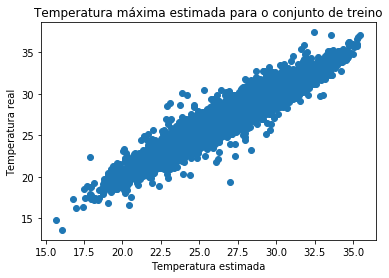

In [43]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax)
plt.title("Temperatura máxima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [44]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(grid_searchTempMax.predict(X_trainTempMax), Y_trainTempMax))

[[1.         0.95980439]
 [0.95980439 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMax = grid_searchTempMax.predict(X_testTempMax)

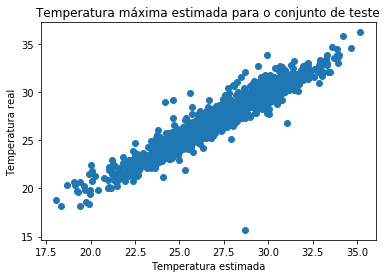

In [46]:
#Gráfico que mostra a relação entre ROP real e ROP previsto
plt.scatter(Y_predTempMax, Y_testTempMax)
plt.title("Temperatura máxima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [47]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_predTempMax, Y_testTempMax))

[[1.         0.95178144]
 [0.95178144 1.        ]]


In [48]:
#Erro absoluto médio entre o ROP previsto e o real
print(mean_absolute_error(Y_testTempMax, Y_predTempMax))

0.6585645980896938


In [49]:
#Erro quadrático médio entre o ROP previsto e o real
print(mean_squared_error(Y_testTempMax, Y_predTempMax))

0.8882940607145838


# Modelagem para previsão de Temperatura Mínima

In [0]:
dataTreinoTempMin = dataSet.dropna(subset = ["TempMinima"])

In [0]:
#Separando a variável que será prevista, TempMinima, da base de dados
tempMin = dataTreinoTempMin["TempMinima"]
dataTreinoTempMin = dataTreinoTempMin.drop(columns = "TempMinima")

In [52]:
#Visualizando dados
dataTreinoTempMin.head()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,Mes
397,30.2,11.5,1.8,24.16,75.00,2.033333,0.6,2
398,30.2,11.5,4.2,24.48,74.25,1.400000,0.0,2
399,31.8,10.5,3.0,24.84,72.75,1.233333,0.0,2
400,31.4,8.9,4.0,24.64,72.50,1.133333,0.0,2
401,31.4,8.1,3.0,24.00,74.00,1.633333,0.0,2


In [53]:
tempMin.head()

397    18.8
398    19.2
399    18.2
400    19.2
401    18.0
Name: TempMinima, dtype: float64

In [0]:
colunas = dataTreinoTempMin.columns

In [0]:
#Efetuando uma transformação robusta, trabalhando com os dados entre os percentis 10 e 90
mms = MinMaxScaler(feature_range=(-1, 1))
dataTreinoTempMin = mms.fit_transform(dataTreinoTempMin)

In [56]:
prov = pd.DataFrame(dataTreinoTempMin)
prov.columns = colunas
prov.describe()

,TempMaxima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Precipitacao,Mes
count,12300.000000,12048.000000,12055.000000,12291.000000,12283.000000,12299.000000,12296.000000,12305.000000
mean,0.146344,-0.658482,-0.515041,0.107447,0.132925,-0.418015,-0.946226,0.005563
std,0.257258,0.163957,0.212422,0.280014,0.339138,0.229760,0.146387,0.625794
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.025210,-0.770408,-0.658291,-0.086093,-0.105431,-0.575000,-1.000000,-0.454545
50%,0.159664,-0.602041,-0.527638,0.116998,0.111821,-0.450000,-1.000000,0.090909
75%,0.327731,-0.535714,-0.386935,0.311258,0.361022,-0.287500,-0.987406,0.636364
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [0]:
#Trocando dados faltantes por 0
dataTreinoTempMin = np.nan_to_num(dataTreinoTempMin, copy = False)

In [58]:
#Verificando dimensões do dataSet
print(dataTreinoTempMin.shape)

(12305, 8)


In [0]:
#Separando conjunto de treino e teste
X_trainTempMin, X_testTempMin, Y_trainTempMin, Y_testTempMin = train_test_split(dataTreinoTempMin, tempMin, test_size = 0.1, random_state = 9)

In [0]:
#Modelo de classificação do Keras
estimator = KerasRegressor(build_fn=trainMLP, epochs = 200, verbose = 2)

In [0]:
#Criando o objeto para Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=5)

In [0]:
#Parâmetros para o Grid Search
#Adicionando e alterando parâmetros neste dicionário, pode-se aumentar ou diminuir a quantidade de parâmetros a serem testados na modelagem
parameters = {'batch_size': [10],             
              'camadas': [2],
              'units': [8]}

In [0]:
#Modelagem para buscar os melhores parâmetros
#Por limitações de poder de processamento, retirou-se o n_jobs = -1 dos parâmetros do Grid Search
grid_searchTempMin = GridSearchCV(estimator = estimator, param_grid = parameters,
                     scoring = "neg_mean_squared_error", verbose=500, cv = kfold, return_train_score = True)

In [64]:
#Busca pelos melhores parâmetros
grid_resultTempMin = grid_searchTempMin.fit(X_trainTempMin, Y_trainTempMin)

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] batch_size=10, camadas=2, units=8 ...............................
Epoch 1/200
 - 1s - loss: 186.4447 - mean_absolute_error: 13.1869
Epoch 2/200
 - 1s - loss: 55.2846 - mean_absolute_error: 6.8622
Epoch 3/200
 - 1s - loss: 15.4449 - mean_absolute_error: 3.3501
Epoch 4/200
 - 1s - loss: 7.2764 - mean_absolute_error: 2.2547
Epoch 5/200
 - 1s - loss: 6.5396 - mean_absolute_error: 2.0921
Epoch 6/200
 - 1s - loss: 6.5193 - mean_absolute_error: 2.0770
Epoch 7/200
 - 1s - loss: 4.6565 - mean_absolute_error: 1.7061
Epoch 8/200
 - 1s - loss: 2.0835 - mean_absolute_error: 1.1184
Epoch 9/200
 - 1s - loss: 1.1806 - mean_absolute_error: 0.8423
Epoch 10/200
 - 1s - loss: 0.9494 - mean_absolute_error: 0.7581
Epoch 11/200
 - 1s - loss: 0.8710 - mean_absolute_error: 0.7202
Epoch 12/200
 - 1s - loss: 0.8371 - mean_absolute_error: 0.7064
Epoch 13/200
 - 1s - loss

In [65]:
#Exibição dos melhores resultados
print("Melhor resultado: %f, usando %s" % (grid_resultTempMin.best_score_, grid_resultTempMin.best_params_))
means = grid_resultTempMin.cv_results_['mean_test_score']
stds = grid_resultTempMin.cv_results_['std_test_score']
params = grid_resultTempMin.cv_results_['params']
print("Resultados (Desvio padrão) {Parâmetros}")
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) %r" % (mean, stdev, param))

Melhor resultado: -0.698833, usando {'batch_size': 10, 'camadas': 2, 'units': 8}
Resultados (Desvio padrão) {Parâmetros}
-0.698833 (0.039549) {'batch_size': 10, 'camadas': 2, 'units': 8}


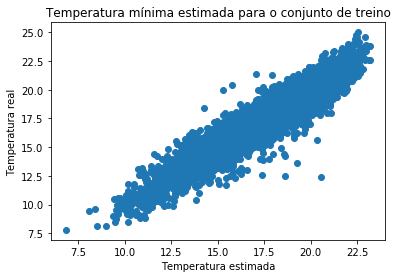

In [66]:
#Gráfico de previsão para o conjunto de treino
plt.scatter(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin)
plt.title("Temperatura mínima estimada para o conjunto de treino")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [67]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(grid_searchTempMin.predict(X_trainTempMin), Y_trainTempMin))

[[1.         0.94914416]
 [0.94914416 1.        ]]


In [0]:
#Previsão com base no resultado da Grid Search
Y_predTempMin = grid_searchTempMin.predict(X_testTempMin)

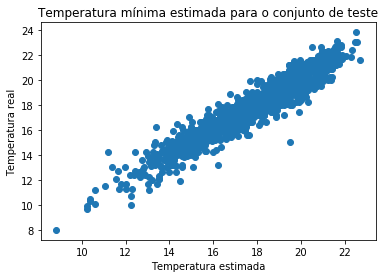

In [69]:
#Gráfico que mostra a relação entre ROP real e ROP previsto
plt.scatter(Y_predTempMin, Y_testTempMin)
plt.title("Temperatura mínima estimada para o conjunto de teste")
plt.xlabel("Temperatura estimada")
plt.ylabel("Temperatura real")
plt.show()

In [70]:
#Mostrando uma matriz de correlação das variáveis com a melhor modelagem
print(np.corrcoef(Y_predTempMin, Y_testTempMin))

[[1.         0.95173122]
 [0.95173122 1.        ]]


In [71]:
#Erro absoluto médio entre o ROP previsto e o real
print(mean_absolute_error(Y_testTempMin, Y_predTempMin))

0.6006764110562087


In [72]:
#Erro quadrático médio entre o ROP previsto e o real
print(mean_squared_error(Y_testTempMin, Y_predTempMin))

0.5918540563250014
